In [2]:
import numpy as np
from numpy import nanmedian
import scipy
import scipy.signal
import math
from numpy.fft import fft, ifft, rfft, fft2, ifft2
import rasterio
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
def filt5(lon, lat, ingrid, nodata=np.nan):
    """
    Find peaks in 5 directions. Flag as 5
    """
    
    nodatidx = ingrid.flatten()*np.nan ## creates single dim array with as much values as the matrix ingrid, with NANs
    outgrid = np.zeros(ingrid.shape)   ## outgrid is a matrix with the shape of ingrid, full of Zeros
    
    #l1 = len(lon)
    #l2 = len(lat)
    l1 = len(lat)
    l2 = len(lon)

    
    for i in range(3, l1-1):   
        for j in range(3, l2-1):
            subg = ingrid[(i-3):(i+2), (j-3):(j+2)] # slice with data from row (i-2,i-1, i, i+1, i+2) and columns (j-2, j-1, j, j+1, j+2)
            if np.isnan(subg).sum()==25:    #if all values in submatrix subg are null values:
                outgrid[i,j] = 0
            else:
                vec = np.array(subg).T.flatten()    ## convert matrix to vector
                ma = np.argmax(subg.flatten())
                mi = np.argmin(subg.flatten())
                
                if ma==12 or mi==12:     #se se tratar do valor meio da matrix
                    outgrid[i-1,j-1] = 1
                else:
                    outgrid[i-1,j-1] = 0
    
    return outgrid

In [4]:
def filt3(lon, lat, ingrid, grid5):
    """
    Find peaks in 3 directions. FLag as 3
    """
    
    outgrid = ingrid*0   #make all zeros. in python if matrix ingrid has null values, they'll stay null after (*0)
    #l1=len(lon)
    #l2=len(lat)
    l1 = len(lat)
    l2 = len(lon)
    
    for i in range(3, l1-1):   
        for j in range(3, l2-1):
            if (grid5[i,j]==0):
                subg = ingrid[(i-2):(i+1), (j-2):(j+1)]
                if np.isnan(subg).sum()==9:
                    outgrid[i-1,j-1] = ingrid[i-1,j-1]
                else:
                    vec = np.array(subg).T.flatten()
                    ma = np.argmax(subg.flatten())
                    mi = np.argmin(subg.flatten())
                    
                    if (ma==4 or mi==4):     #pixel do meio
                        outgrid[i-1,j-1] = nanmedian(subg)
                    else:
                        outgrid[i-1,j-1] = ingrid[i-1,j-1]
            
            else:
                outgrid[i-1,j-1] = ingrid[i-1,j-1]
                
    return outgrid

In [16]:
def boa(lon, lat, ingrid, nodata = np.nan, direction = False):
    
    def filter2(x, filt):
        
        dx = x.shape                          
        df = filt.shape                       
        cx = tuple(elem//2 for elem in dx)    
        cf = tuple(elem//2 for elem in df)    

        wf = np.zeros(shape=dx)               

        wf[cx[0]-cf[0]-1:cx[0]+cf[0], cx[1]-cf[1]-1:cx[1]+cf[1]] = filt    

        wf = fft2(wf)                        
    
        dim_x = np.array(dx[0:2])
        dim_x =np.append(dim_x, math.prod(dx)/math.prod(dx[0:2]))     

        aux1 = np.arange(cx[0],dx[0]+1)
        aux2 = np.arange(1,cx[0])
        index1 = np.concatenate((aux1, aux2), axis=None)  
        index1 = index1-1

        aux3 = np.arange(cx[1], dx[1]+1)
        aux4 = np.arange(1,cx[1])
        index2 = np.concatenate((aux3, aux4), axis=None) 
        index2 = index2-1

        pdx = math.prod(dim_x[0:2])                                   
        
        y = (scipy.fft.ifft2(scipy.fft.fft2(x)*wf)).real

        y = np.array([[y[i][j] for j in index2] for i in index1])
        
        return y
    
#O problema é que na função fft() em R há um parametro inverse=T que altera a ordem da matriz
# Não estou a conseguir arranjar forma de replicar os efeitos desse parametro no codigo em Python   
    
#======================================================#
# Main BOA algorithm                                   
#======================================================#      
    gx = np.matrix([[-1,0,1],[-2,0,2],[-1,0,1]])   
    gy = np.matrix([[1,2,1],[0,0,0],[-1,-2,-1]])
        
    np.nan_to_num(ingrid, nan=-9999, posinf=-9999, neginf=-9999) ##replace NaN and inf values with -9999
        
    grid5 = filt5(lon, lat, ingrid, nodata = nodata)
    grid35 = filt3(lon, lat, ingrid, grid5)

    # make an index of bad values and land pixels.
    grid35 = grid35.astype("float")
    grid35[grid35 == -9999]=np.nan
    naidx = np.isnan(grid35)       
    # convert these to zeros for smoothing purposes
    grid35[naidx]=0  

    # perform the smoothing (Sobel filter)  
    tgx = filter2(grid35, gx)
    tgy = filter2(grid35, gy)
        
    tx = tgx/np.nansum(abs(np.array(gx).flatten()))
    ty = tgy/np.nansum(abs(np.array(gy).flatten()))
    front = np.sqrt((tx**2)+(ty**2))


#======================================================#
# landmask and edge dilation
#======================================================#

    land = naidx*1
    land = land.astype("float")

    land[land==1] = np.nan
    land[~np.isnan(land)] = 1

    
#======================================================#
# landmask and edge dilation using raster!
#======================================================#

    l2=lon.size    #using size because lon and lat are matrices
    l1=lat.size

    midx = land*np.nan

    midx[5:(l1-2), 5:(l2-2)] = 1

    land = np.multiply(land, midx)

    ########################################## Talvez arranjar um pouco mais o código
    
    
    ssr = np.flip(front.T, 0)
    

    #Apply the sliding window kernell to the land matrix
    mask = scipy.signal.convolve2d(np.flip(land.T, 0), np.array([0,0,0,0,1,0,0,0,0]).reshape(3,3), boundary='symm', mode='same')



    matrix_front =  mask * np.flip(front.T, 0)   #matrix of mask raster file * matrix of ssr raster file

    ####################################################


    if direction==True:
#   ************************************
#   *** Calculate Gradient Direction ***
#   ************************************
        
        n = ingrid.size       #nr os elements of the grid matrix
        grid_shape = ingrid.shape

        GRAD_DIR = np.zeros(n)

        for i in range(n):
            GRAD_DIR[i] = math.atan2(tgy.flatten()[i], tgx.flatten()[i])
    
        GRAD_DIR = GRAD_DIR*180/math.pi

        OK = np.where(GRAD_DIR < 0)

        OK = np.array(OK)

        if OK.size >1:
            GRAD_DIR[OK] = 360 - abs(GRAD_DIR[OK])
    
        GRAD_DIR = (360 - GRAD_DIR + 90) % 360   
        GRAD_DIR = GRAD_DIR.reshape(grid_shape)
        
        
        grad_dir = np.flip(GRAD_DIR.T, 0)


        # create array grdir (result from multiplication of grad_dir_matrix and mask_matrix (its the conv matrix))
        grdir_matrix = np.flip(GRAD_DIR.T, 0)*mask


        #No R eles pôem numa named_list por isso aqui pus num dicionário (algo equivalente)
        dic = {'grdir': grdir_matrix, 'front': matrix_front}
        
    else:
        matrix_front

        
    return matrix_front

In [17]:
lon = np.loadtxt('lon.csv')
lat = np.loadtxt('lat.csv')
ingrid = pd.read_csv('ingrid.csv', header=None)
ingrid = ingrid.to_numpy()

In [19]:
front = boa(lon=lon, lat=lat, ingrid=ingrid, nodata = np.nan, direction = True)

In [21]:
front.shape

(169, 121)

In [23]:
front = np.flip(front, axis=0)

In [24]:
new_matrix = [[front[j][i] for j in range(len(front))] for i in range(len(front[0])-1,-1,-1)]

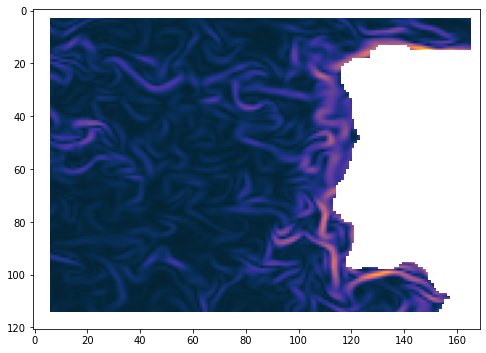

In [25]:
import cmocean
im = plt.imshow(new_matrix, cmocean.cm.thermal)
plt.rcParams["figure.figsize"] = (8,8)
#plt.colorbar(im, orientation='horizontal', fraction=0.07, pad=0.06, aspect=50)
plt.show()